# **Análisis de Series de tiempo**
## Usando la técnica Prophet

# 1.Objetivo

La idea es poder leer el archivo que contiene la historia de Imacec chileno a partir de 2018 para el indicador general. Existen diferentes maneras de leer la información pero no es parte del objetivo presente código.

El espíritu es poder entregar un código simple para realizar un forecast para este indicador u otro, usando Prophet.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet

In [2]:
data = [
    96.6, 92.8, 105.2, 102.0, 101.7, 98.5, 93.8, 98.2,
    94.3, 102.2, 105.6, 109.0, 98.6, 93.3, 106.5, 103.5, 103.2,
    99.1, 96.4, 101.6, 97.3, 97.7, 100.4, 110.0, 99.7, 95.9,
    102.1, 88.1, 86.9, 85.2, 85.0, 90.2, 92.1, 96.3, 101.3,
    110.6, 96.2, 94.0, 109.0, 101.5, 103.8, 102.6, 99.7, 106.4,
    104.5, 109.0, 114.9, 120.2, 103.3, 98.9, 115.2, 107.2,
    109.1, 105.4, 99.8, 107.7, 105.3, 107.2, 111.3, 118.3, 104.6,
    98.7, 113.3, 106.9, 108.8, 105.6, 103.0, 108.1, 106.1,
    109.1, 113.1, 118.3, 107.9, 104.2, 115.0, 111.2, 109.2,
    104.9, 107.1, 110.2, 106.3, 112.0, 115.8, 126.3
    ]

# Fechas correspondientes
dates = pd.date_range(start='2018-01-01', periods=len(data), freq='M')
df = pd.DataFrame({'ds': dates, 'y': data})

#df['fecha'] = pd.DatetimeIndex(df['fecha'])
df.dtypes

<ipython-input-2-00b45c65ad78>:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start='2018-01-01', periods=len(data), freq='M')


,0
ds,datetime64[ns]
y,float64


# 2.Presentación serie

La serie muestra historia desde enero de 2018, y se refleja todo el periodo de pandemia, en el cual el indicador sufrió una caída que no se explica por efectos de la misma serie.

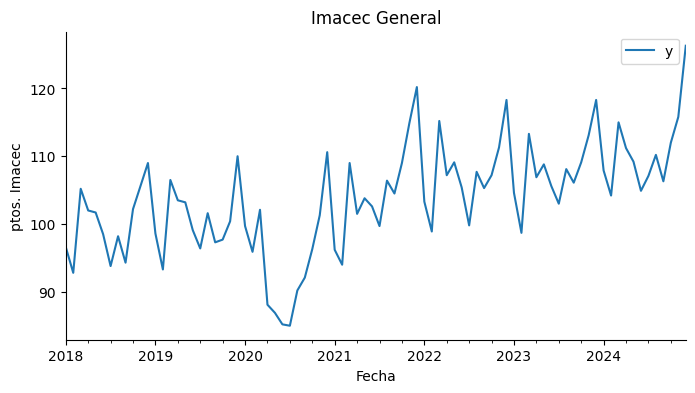

In [4]:
df.set_index('ds').plot(figsize=(8, 4), title='Imacec General')
plt.xlabel('Fecha');plt.ylabel('ptos. Imacec')
plt.gca().spines[['top', 'right']].set_visible(False)

# 3.Entrenamiento

Para la fase de entrenamiento se entregará la serie tal como es su naturaleza (no estacionaria) y con ello se obtendrá su forecast.

In [5]:
model = Prophet()
model.fit(df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkcspurrd/_9ivmgv7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkcspurrd/43q088hi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98176', 'data', 'file=/tmp/tmpkcspurrd/_9ivmgv7.json', 'init=/tmp/tmpkcspurrd/43q088hi.json', 'output', 'file=/tmp/tmpkcspurrd/prophet_model7r6v5p8f/prophet_model-20250526163244.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
16:32:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:32:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


#4.Forecast y error

Una vez entrenado el modelo, la serie de tiempo, está en condiciones de entregar una proyección. Para poder medir la calidad de la proyección, la serie entregada fue hasta diciembre, dejando "oculto" los 3 últimos meses observados para calcular un error emulando condiciones reales.

##4.1 Valores reales

Los valores reales observados fueron: 111.0, 104.2, 119.3 para el primer trimestre de 2025. Dichos indicadores serán de utilidad para el calculo de errores.

In [6]:
df_real = [111, 104.2, 119.3]
date_real = pd.date_range(start='2025-01-01', periods=len(df_real), freq='M')
df_real = pd.DataFrame({'ds': date_real, 'y_real': df_real})
df_real['ds'] = pd.DatetimeIndex(df_real['ds'])

<ipython-input-6-c1923130ee38>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_real = pd.date_range(start='2025-01-01', periods=len(df_real), freq='M')


##4.2 Forecast

In [7]:
future = model.make_future_dataframe(periods = 3, freq = 'M')
forecast = model.predict(future)
forecast_future = forecast.tail(3)

/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


In [8]:
future_dates = pd.date_range(start=df['ds'].iloc[-1] + pd.offsets.MonthBegin(), periods=3, freq='MS')
forecast_series = pd.Series(forecast_future['yhat'].values, index=future_dates)

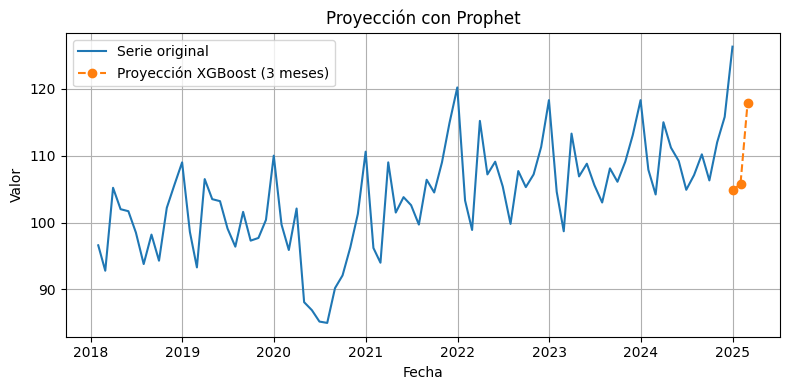

In [9]:
plt.figure(figsize=(8, 4))
plt.plot(df['ds'], df['y'], label='Serie original')
plt.plot(forecast_series.index, forecast_series.values, label='Proyección XGBoost (3 meses)', linestyle='--', marker='o')
plt.title('Proyección con Prophet')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
date_fcts = pd.date_range(start='2025-01-01', periods=len(forecast_series.tolist()), freq='M')
df_fcts = pd.DataFrame({'ds': date_fcts, 'yhat': forecast_series.tolist()})
df_fcts['ds'] = pd.DatetimeIndex(df_fcts['ds'])

<ipython-input-10-15d164ebadfc>:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_fcts = pd.date_range(start='2025-01-01', periods=len(forecast_series.tolist()), freq='M')


##4.3 MAPE

El error puede ser calculado de diferentes maneras, siendo el MAPE calculado como:
$MAPE_{n}=\frac{1}{n}\sum_{i=1}^{n}|(y_{obs,i}-y_{fcst,i})/y_{obs,i}|$.

Por tanto, el error es:

In [11]:
df_mape = df_real.merge(df_fcts, how='inner', on='ds')
df_mape

,ds,y_real,yhat
0,2025-01-31,111.0,104.807066
1,2025-02-28,104.2,105.805228
2,2025-03-31,119.3,117.814517


In [12]:
absolute_percentage_error = abs((df_mape['yhat'] - df_mape['y_real']) / df_mape['y_real'])
mape = absolute_percentage_error.mean()

print(f"El MAPE es: {round(mape*100,2)}%")

El MAPE es: 2.79%
